In [2]:
from colorthief import ColorThief
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.image as mpimg
import cv2 as cv
from skimage.color import deltaE_ciede2000
import json
from tqdm import tqdm


In [ ]:
# extract color palette
from concurrent.futures import ThreadPoolExecutor

palette_size = 30
with open('../sources/metadata/image_database.json', 'r') as f:
    image_database = json.load(f) 
        

all_images = (
    image_database[0]['images'] + 
    image_database[1]['images'] + 
    image_database[2]['images'] + 
    image_database[3]['images']
    )

def process_single_image(image_info):
    progress_bar.update(1)
    try:
        image_path= image_info['path']
        color_thief = ColorThief(image_path)
        palette = color_thief.get_palette(color_count=palette_size)
        image_info['color_palette'] = palette
    except Exception as e:
        image_info['color_palette'] = []
        
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(process_single_image, img): img 
        for img in all_images
    }
    progress_bar = tqdm(total=len(futures), desc="Processing images", unit="image")
    
progress_bar.close()
        


Processing images: 100%|█████████▉| 1717/1721 [10:06<00:01,  2.83image/s]


In [ ]:
with open('../sources/metadata/image_database.json', 'w') as f:
    json.dump(image_database, f, indent=4)

In [ ]:
# search all image by color palette
def similar_image_by_color(color, data, similarity_threshold = 50):
    similar_images = []
    for element in data:
        try:  
            image_path = element['path']
            palette = element['color_palette']
            score = 0
            for sub_color in palette:
                sub = np.zeros((1, 1, 3), dtype=np.uint8)
                sub[0, 0] = [sub_color[0], sub_color[1], sub_color[2]]
                lab = cv.cvtColor(sub, cv.COLOR_RGB2LAB)
                sub_color = lab[0][0] # [0, lab[0][0][1], lab[0][0][2]]
                diff = deltaE_ciede2000(color, sub_color)
                # if diff < similarity_threshold:
                score += diff
            score /= len(palette)
            # print(score, image_path)
            if score < similarity_threshold:
                similar_images.append({
                    'path': image_path,
                    'score': score
                })
        except Exception as e:
            print(f"Error extracting color palette from {image_path} : {str(e)}")


    sorted_dict = sorted(similar_images, key=lambda item: item['score'], reverse=False)
    return sorted_dict

Error extracting color palette from D:\image_search_engine_ai-end\folder\camera\000054.jpg : division by zero


C:\Users\DELL\AppData\Local\Temp\ipykernel_26592\3991990873.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sub[0, 0] = [sub_color[0], sub_color[1], sub_color[2]]


Error extracting color palette from D:\image_search_engine_ai-end\folder\camera\000092.jpg : division by zero
Error extracting color palette from D:\image_search_engine_ai-end\folder\summer\000218.jpg : division by zero


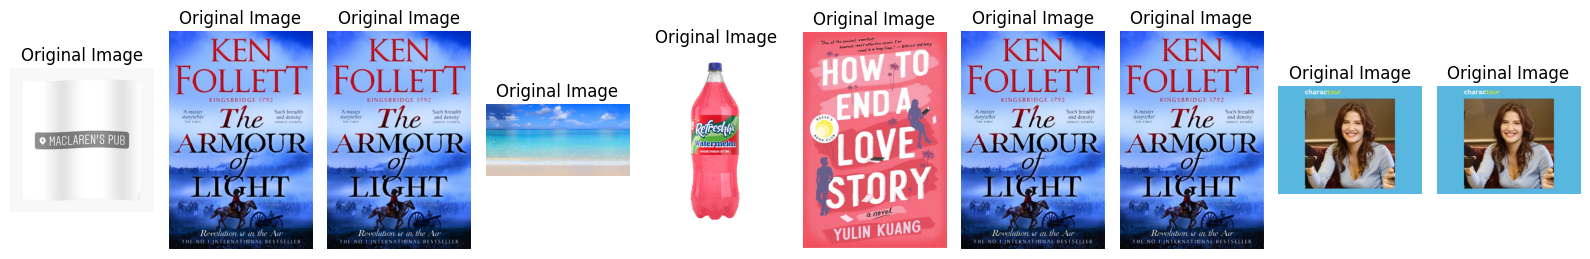

In [ ]:

color = [255, 0, 255]  # Example: blue-like color

plt.figure(figsize=(16, 9))
# Create a 1x1 pixel image
image = np.zeros((1, 1, 3), dtype=np.uint8)
image[0, 0] = color
lab = cv.cvtColor(image, cv.COLOR_RGB2LAB)
color = lab[0][0] #[0, lab[0][0][1], lab[0][0][2]]

similar = similar_image_by_color(color, all_images, similarity_threshold=50)
for i, element in enumerate(similar[:10]):
    plt.subplot(1, len(similar[:10]), i+1)
    plt.imshow(Image.open(element['path']))
    plt.title("Original Image")
    plt.axis('off')
plt.tight_layout()
plt.show()